In [248]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Episode Generator

In [249]:
def generate_episode(state_info, action, policy):
    # player = [sum, aces]
    # state = [player usable ace(0-1), player sum(12-21), dealer showing(1-10)]
    player, dealer, dealer_faceup = state_info
    actions = [action]

    while action == 0:
        card = np.random.randint(1, 14)
        if card == 1: ## ace
            player.append([player[-1][0] + 11, player[-1][1] + 1])
        else:
            player.append([player[-1][0] + min(10, card), player[-1][1]])

        if player[-1][0] > 21:
            if player[-1][1] > 0:
                player[-1][0] -= 10
                player[-1][1] -= 1
            else: break

        if player[-1][0] > 21:
            break

        state = [int(player[-1][1] > 0), player[-1][0] - 12, dealer_faceup - 1]
        action = policy[state[0]][state[1]][state[2]]
        actions.append(action)

    if player[-1][0] >= 21:
        return player, dealer, dealer_faceup, actions

    while True:
        if dealer[-1][0] >= 17:
            break

        card = np.random.randint(1, 14)
        if card == 1: ## ace
            dealer.append([dealer[-1][0] + 11, dealer[-1][1] + 1])
        else:
            dealer.append([dealer[-1][0] + min(10, card), dealer[-1][1]])

        if dealer[-1][0] > 21:
            if dealer[-1][1] > 0:
                dealer[-1][0] -= 10
                dealer[-1][1] -= 1
            else: break

    return player, dealer, dealer_faceup, actions

In [250]:
def get_initial_state():
    player = [np.random.randint(12, 22), np.random.randint(0, 2)]

    dealer_cards = np.random.randint(2, 12, size=[2])
    dealer_sum = np.sum(dealer_cards)
    dealer_showing = dealer_cards[0]
    dealer_ace = np.sum((dealer_cards == 11).astype(int))

    if dealer_showing == 11:
        dealer_showing = 1

    if dealer_sum == 22:
        dealer_sum -= 10
        dealer_ace -= 1

    state_info = [[player], [[dealer_sum, dealer_ace]], dealer_showing]

    # 0 --> hit, 1 --> stick
    action = np.random.randint(0, 2)
    # if player[0] == 21:
    #     action = 1

    return [state_info, action]

## Value estimation

In [251]:
def get_value_estimation(episodes):
    # state: [
    #   usable ace:             0 --> NO, 1 --> YES
    #   player sum:             0 --> 12, 1 --> 13, ..., 9 --> 21
    #   dealer showing card:    0 --> 1, ..., 9 --> 10
    # ]

    ## state --> [player usable ace, player sum, dealer face up card]

    policy = np.zeros([2, 10, 10], dtype='int')
    policy[ : , 8 : , : ] = np.full([2, 2, 10], 1).astype(int)
    
    action_values = np.zeros([2, 10, 10, 2], dtype='f')
    action_frequencies = np.zeros([2, 10, 10, 2], dtype='int')
    values = np.full([2, 10, 10, 2], 1, dtype='f')

    # return values, policy

    rewards = 0
    # print(episodes)
    for episode in range(episodes):
        s0, a0 = get_initial_state()
        player, dealer, dealer_faceup, actions = generate_episode(s0, a0, policy)

        reward = 0

        ## bust
        if player[-1][0] > 21:
            reward = -1
            player = player[ : -1]

        elif dealer[-1][0] > 21: reward = 1

        ## win
        elif player[-1][0] > dealer[-1][0]: reward = 1
        elif player[-1][0] < dealer[-1][0]: reward = -1

        # print("===========START=============")
        # print("s0\t\t\t:", s0)
        # print("a0\t\t\t:", a0)
        # print("player\t\t\t:", player)
        # print("dealer\t\t\t:", dealer)
        # print("dealer_faceup\t\t:", dealer_faceup)
        # print("actions\t\t\t:", actions)
        # print("reward\t\t\t:", reward)
        # print("===========OVER=============")

        for time_step in range(len(player) - 1, -1, -1):
            usable_ace = min(1, player[time_step][1])
            id = (usable_ace, player[time_step][0] - 12, dealer_faceup - 1, actions[time_step])

            action_frequencies[id] += 1
            action_values[id] += reward
            values[id] = action_values[id] / action_frequencies[id]

            ## update policy
            s_t = (usable_ace, player[time_step][0] - 12, dealer_faceup - 1)
            policy[s_t] = np.argmax(values[s_t])
        

    return values, policy

In [252]:
np.random.seed(0)
values, policy = get_value_estimation(5_000_000)
## state --> [player usable ace, player sum, dealer face up card]
# 0 --> hit, 1 --> stick

Black = Stick
White = Hit


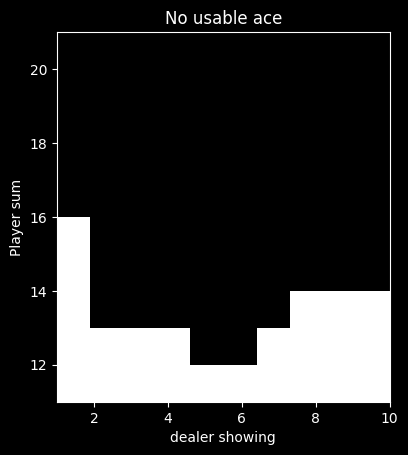

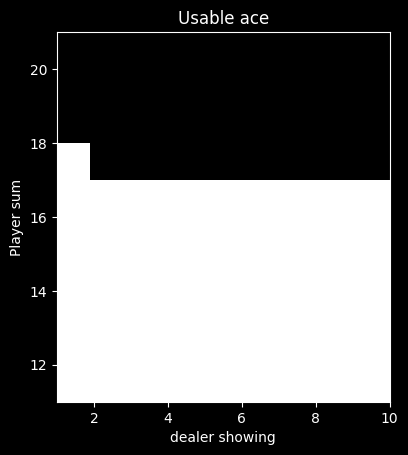

In [253]:
print("Black = Stick\nWhite = Hit")
plt.imshow(policy[0], cmap='Greys', origin='lower', extent=[1, 10, 11, 21])
plt.xlabel("dealer showing")
plt.ylabel("Player sum")
plt.title("No usable ace")
plt.legend
plt.show()

plt.imshow(policy[1], cmap='Greys', origin='lower', extent=[1, 10, 11, 21])
plt.xlabel("dealer showing")
plt.ylabel("Player sum")
plt.title("Usable ace")
plt.legend
plt.show()

In [254]:
def plot_value_esitmates(episodes, values):
    # Set up grid and test data
    nx, ny = 10, 10
    x = range(nx)
    y = range(ny)

    hf = plt.figure()
    plot1 = hf.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    plot1.plot_surface(X, Y, values[0])
    plt.title("No usable ace, {} episodes".format(episodes))
    plt.xlabel("Player sum")
    plt.ylabel("Dealer showing")
    plt.show()

    hf = plt.figure()
    plot2 = hf.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    plot2.plot_surface(X, Y, values[1])
    plt.title("Usable ace, {} episodes".format(episodes))
    plt.xlabel("Player sum")
    plt.ylabel("Dealer showing")

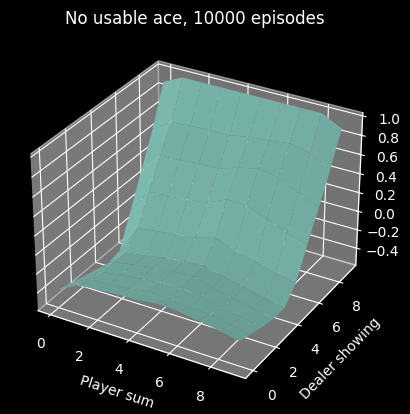

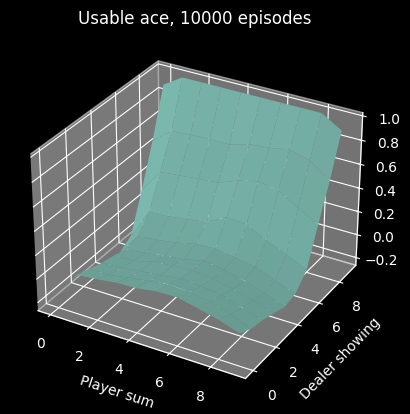

In [255]:
plot_value_esitmates(10000, np.max(values, axis=3))